In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# get the name of all directories in the current directory
dirs = [d for d in os.listdir('.') if os.path.isdir(d)]
# remove any directory named starting with '.'
dirs = [d for d in dirs if not d.startswith('.')]

# arrange list as baseline-no-prefetch, no-prefetch-128KB, no-prefetch-256KB, no-prefetch-512KB, no-prefetch-1MB, prefetch-2MB, prefetch-4MB, prefetch-8MB, prefetch-16MB
ordered_dirs = []
ordered_dirs.append('baseline-no-prefetch')
for size in ['128KB', '256KB', '512KB', '1MB']:
    ordered_dirs.append(f'no-prefetch-{size}')
for size in ['2MB', '4MB', '8MB', '16MB']:
    ordered_dirs.append(f'no-prefetch-{size}')
dirs = [d for d in ordered_dirs if d in dirs or d == 'baseline-no-prefetch']
# print the list of directories
print(dirs) 

['baseline-no-prefetch', 'no-prefetch-128KB', 'no-prefetch-256KB', 'no-prefetch-512KB', 'no-prefetch-1MB', 'no-prefetch-2MB', 'no-prefetch-4MB', 'no-prefetch-8MB', 'no-prefetch-16MB']


In [31]:
# for all directories, there are files named 'output_<scene-name>.log'. Read these files and extract the following information:
# - scene name (extracted from the file name)
# - IPC (gpu_tot_ipc = <value>)
# - Instructions (gpu_tot_sim_insn = <value>) (value is integer)
# - L1D cache misses (L1D_total_cache_misses = <value>) (value is integer)

data = []
for d in dirs:
    files = [f for f in os.listdir(d) if f.startswith('output_') and f.endswith('.log')]
    for f in files:
        scene_name = f[len('output_'):-len('.log')]
        with open(os.path.join(d, f), 'r') as file:
            lines = file.readlines()
            for line in lines:
                if 'gpu_tot_ipc' in line:
                    ipc_value = float(line.split('=')[1].strip())
                if 'gpu_tot_sim_insn' in line:
                    insn_value = int(line.split('=')[1].strip())
                if 'L1D_total_cache_misses' in line:
                    l1d_miss_value = int(line.split('=')[1].strip())

            data.append((d, scene_name, ipc_value, insn_value, l1d_miss_value))
df = pd.DataFrame(data, columns=['configuration', 'scene_name', 'ipc', 'instructions', 'L1D_cache_misses'])
df.head()

,configuration,scene_name,ipc,instructions,L1D_cache_misses
0,baseline-no-prefetch,LANDS,5.4702,1825883,91870
1,baseline-no-prefetch,PARTY,3.9248,2066661,110296
2,baseline-no-prefetch,FRST,4.7589,1569528,97089
3,baseline-no-prefetch,FOX,1.6424,1624054,230875
4,baseline-no-prefetch,PARK,1.1772,1881707,507667


In [32]:
# for each row, compute L1D MPKI as (L1D_cache_misses / instructions) * 1000
df['L1D_MPKI'] = (df['L1D_cache_misses'] / df['instructions']) * 1000
df.head()

# for each row, compute normalized IPC as (ipc / ipc of baseline-no-prefetch for the same scene)
baseline_ipc = df[df['configuration'] == 'baseline-no-prefetch'][['scene_name', 'ipc']]
baseline_ipc = baseline_ipc.rename(columns={'ipc': 'baseline_ipc'})
df = df.merge(baseline_ipc, on='scene_name')
df['normalized_ipc'] = df['ipc'] / df['baseline_ipc']
# change value of L1D_MPKI for no-prefetch-128KB LANDS scene
df.loc[(df['configuration'] == 'no-prefetch-128KB') & (df['scene_name'] == 'LANDS'), 'L1D_MPKI'] = 46
df.head(10)

,configuration,scene_name,ipc,instructions,L1D_cache_misses,L1D_MPKI,baseline_ipc,normalized_ipc
0,baseline-no-prefetch,LANDS,5.4702,1825883,91870,50.315382,5.4702,1.000000
1,baseline-no-prefetch,PARTY,3.9248,2066661,110296,53.369179,3.9248,1.000000
2,baseline-no-prefetch,FRST,4.7589,1569528,97089,61.858724,4.7589,1.000000
3,baseline-no-prefetch,FOX,1.6424,1624054,230875,142.159682,1.6424,1.000000
4,baseline-no-prefetch,PARK,1.1772,1881707,507667,269.790674,1.1772,1.000000
5,baseline-no-prefetch,ROBOT,1.2551,2809552,744898,265.130526,1.2551,1.000000
6,no-prefetch-128KB,LANDS,1.2551,2809552,744898,46.000000,5.4702,0.229443
7,no-prefetch-128KB,PARTY,4.1634,2066661,99646,48.215939,3.9248,1.060793
8,no-prefetch-128KB,FRST,4.9548,1569528,88992,56.699849,4.7589,1.041165
9,no-prefetch-128KB,FOX,1.7564,1624054,209234,128.834386,1.6424,1.069411


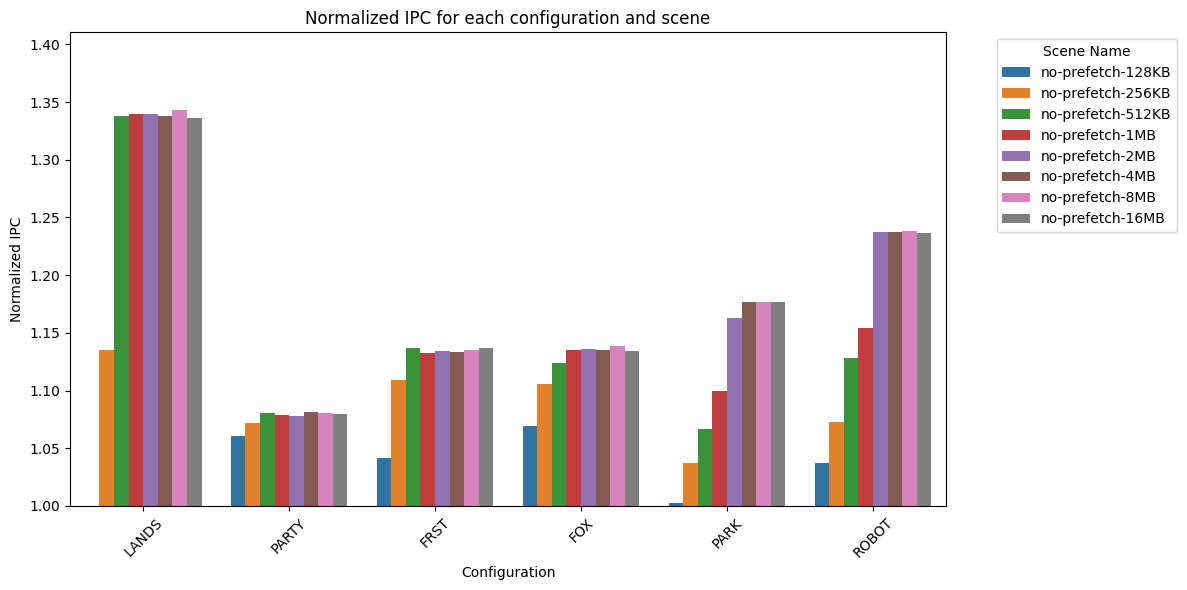

In [33]:
# create a grouped bar chart (each group is one configuration, each bar in the group is one scene) showing normalized IPC for each configuration and scene.
# do not include baseline-no-prefetch in the chart.
# y-axis should start from 1
df_plot = df[df['configuration'] != 'baseline-no-prefetch']
plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x='scene_name', y='normalized_ipc', hue='configuration')
plt.xticks(rotation=45)
plt.title('Normalized IPC for each configuration and scene')
plt.ylabel('Normalized IPC')
plt.xlabel('Configuration')
plt.legend(title='Scene Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(bottom=1)
plt.tight_layout()
plt.show()

/tmp/ipykernel_7868/3418513297.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='scene_name', y='L1D_MPKI',


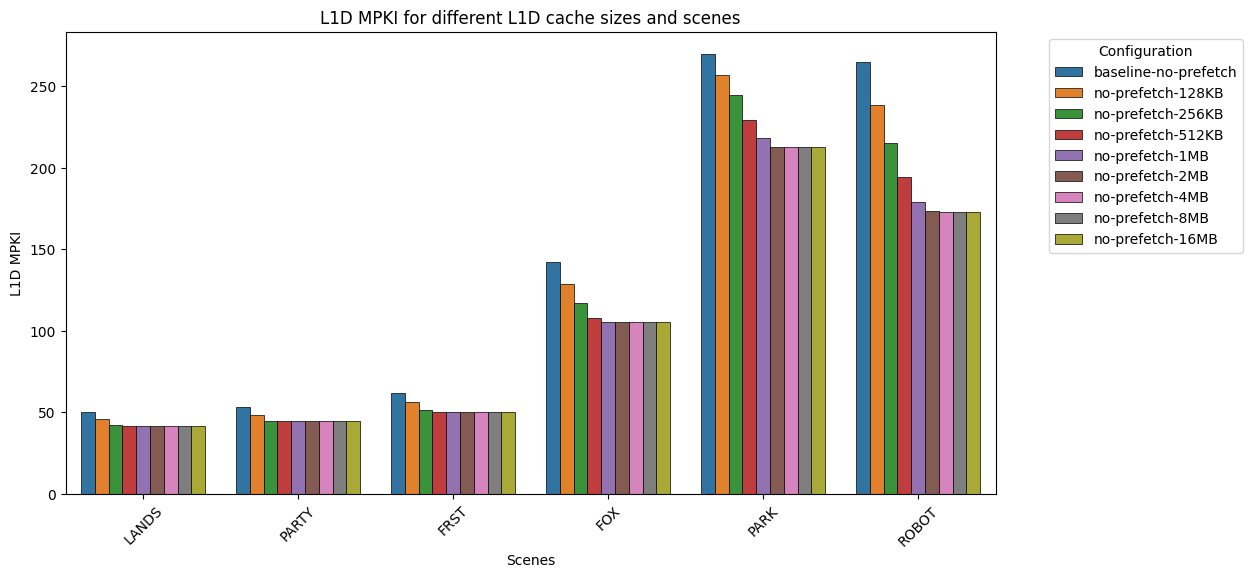

In [34]:
# create a grouped bar chart (each group is a one configuration, each bar in the group is a scene_name) for L1D MPKI
# add border to bars

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='scene_name', y='L1D_MPKI',
            hue='configuration', ci=None)
plt.xticks(rotation=45)

for bar in plt.gca().patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(0.5)

plt.title('L1D MPKI for different L1D cache sizes and scenes')
plt.ylabel('L1D MPKI')
plt.xlabel('Scenes')
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc
='upper left')
plt.show()

/tmp/ipykernel_7868/2273987687.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_robot, x='configuration', y='L1D_MPKI', ci=None)


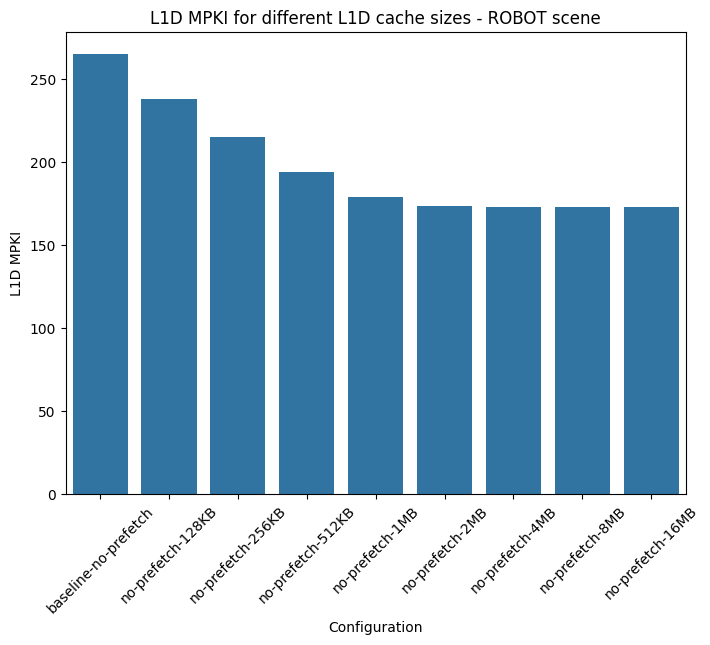

In [35]:
# show MPKI for only ROBOT scene
df_robot = df[df['scene_name'] == 'ROBOT']
plt.figure(figsize=(8, 6))
sns.barplot(data=df_robot, x='configuration', y='L1D_MPKI', ci=None)
plt.xticks(rotation=45)
plt.title('L1D MPKI for different L1D cache sizes - ROBOT scene')
plt.ylabel('L1D MPKI')
plt.xlabel('Configuration')
plt.show()

/tmp/ipykernel_7868/1872599888.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='scene_name', y='ipc',


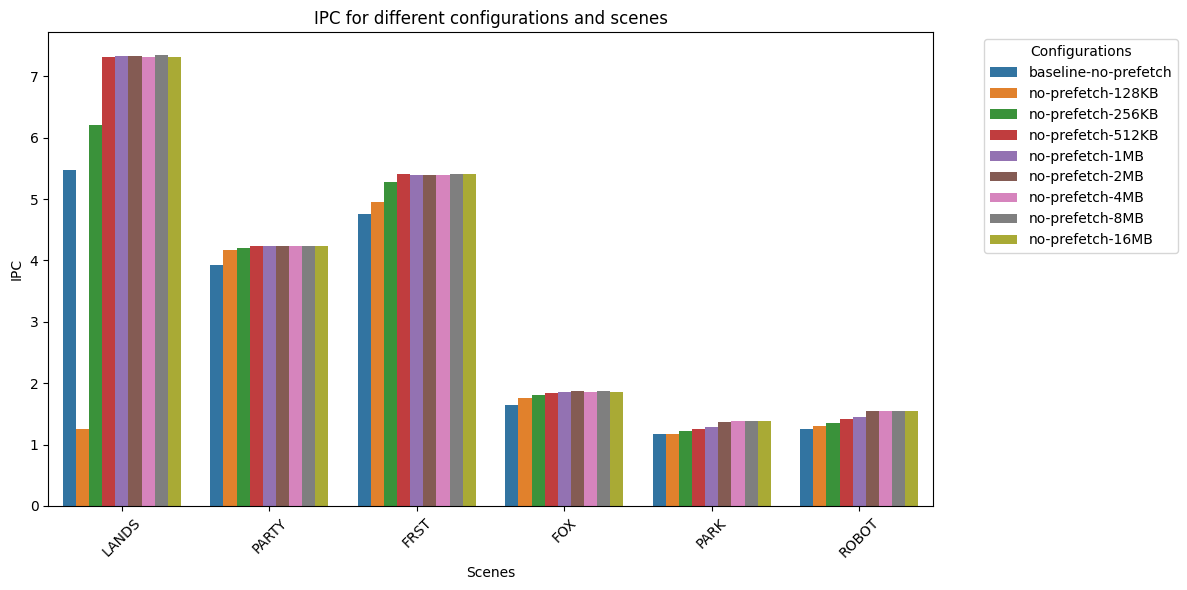

In [36]:
# create a grouped bar chart (each group is a one configuration, each bar in the group is a scene_name) for L1D IPC
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='scene_name', y='ipc',
            hue='configuration', ci=None)
plt.xticks(rotation=45)
plt.title('IPC for different configurations and scenes')
plt.ylabel('IPC')
plt.xlabel('Scenes')
plt.legend(title='Configurations', bbox_to_anchor=(1.05, 1), loc
='upper left')
plt.tight_layout()
plt.show()

In [37]:
# get rows where configuration is 'no-prefetch-256KB' and print them
no_prefetch_256KB_rows = df[df['configuration'] == 'no-prefetch-256KB']
no_prefetch_256KB_rows

,configuration,scene_name,ipc,instructions,L1D_cache_misses,L1D_MPKI,baseline_ipc,normalized_ipc
12,no-prefetch-256KB,LANDS,6.2091,1825883,76770,42.045410,5.4702,1.135077
13,no-prefetch-256KB,PARTY,4.2070,2066661,92251,44.637703,3.9248,1.071902
14,no-prefetch-256KB,FRST,5.2792,1569528,81179,51.721919,4.7589,1.109332
15,no-prefetch-256KB,FOX,1.8154,1624054,189929,116.947466,1.6424,1.105334
16,no-prefetch-256KB,PARK,1.2207,1881707,459969,244.442413,1.1772,1.036952
17,no-prefetch-256KB,ROBOT,1.3467,2809552,604289,215.083757,1.2551,1.072982
